In [285]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from collections import Counter
import pickle

In [286]:
df = pd.read_csv("survey_results_public.csv")

In [287]:
df = df[["RemoteWork", "EdLevel", "YearsCodePro", "DevType", "OrgSize", "Country", "LanguageHaveWorkedWith", "DatabaseHaveWorkedWith", "PlatformHaveWorkedWith", "ConvertedCompYearly"]]

In [288]:
df = df.rename(columns={
    "RemoteWork" : "WorkMode",
    "YearsCodePro": "Experience", 
    "LanguageHaveWorkedWith": "Language",
    "DatabaseHaveWorkedWith": "DataBase",
    "PlatformHaveWorkedWith": "Platform",
    "ConvertedCompYearly": "Salary"
})

In [289]:
df.isnull().sum()

WorkMode      15374
EdLevel        1211
Experience    23048
DevType       12312
OrgSize       24141
Country        1211
Language       2044
DataBase      15749
Platform      25556
Salary        41165
dtype: int64

In [290]:
# i will remove all the rows that has nan.
df = df.dropna(subset=['Salary', 'WorkMode', 'Experience', 'DevType', 'OrgSize', 'Language', 'DataBase', 'Platform'])

In [291]:
df.isnull().sum()

WorkMode      0
EdLevel       0
Experience    0
DevType       0
OrgSize       0
Country       0
Language      0
DataBase      0
Platform      0
Salary        0
dtype: int64

In [292]:
df.shape

(34419, 10)

In [293]:
df.head()

,WorkMode,EdLevel,Experience,DevType,OrgSize,Country,Language,DataBase,Platform,Salary
1,Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",9,"Senior Executive (C-Suite, VP, etc.)",2 to 9 employees,United States of America,HTML/CSS;JavaScript;Python,Supabase,Amazon Web Services (AWS);Netlify;Vercel,285000.0
3,"Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,"Developer, front-end",100 to 499 employees,United States of America,Bash/Shell (all shells);HTML/CSS;JavaScript;PH...,PostgreSQL;Redis,Cloudflare;Heroku,156000.0
4,Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,"Developer, full-stack",20 to 99 employees,Philippines,HTML/CSS;JavaScript;TypeScript,BigQuery;Elasticsearch;MongoDB;PostgreSQL,Amazon Web Services (AWS);Firebase;Heroku;Netl...,23456.0
5,Remote,Some college/university study without earning ...,21,"Developer, back-end",100 to 499 employees,United Kingdom of Great Britain and Northern I...,Bash/Shell (all shells);HTML/CSS;JavaScript;Ru...,BigQuery;Cloud Firestore;PostgreSQL;Redis,Amazon Web Services (AWS);Cloudflare;Google Cloud,96828.0
6,Remote,Some college/university study without earning ...,3,"Developer, full-stack","1,000 to 4,999 employees",United States of America,Ada;Clojure;Elixir;Go;HTML/CSS;Java;JavaScript...,MariaDB;Microsoft SQL Server;MySQL;PostgreSQL;...,Amazon Web Services (AWS);Digital Ocean,135000.0


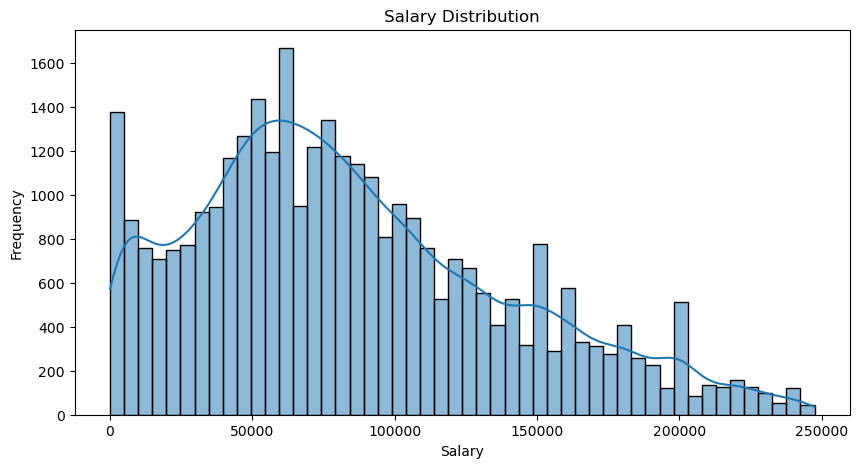

In [324]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['Salary'], bins=50, kde=True)
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

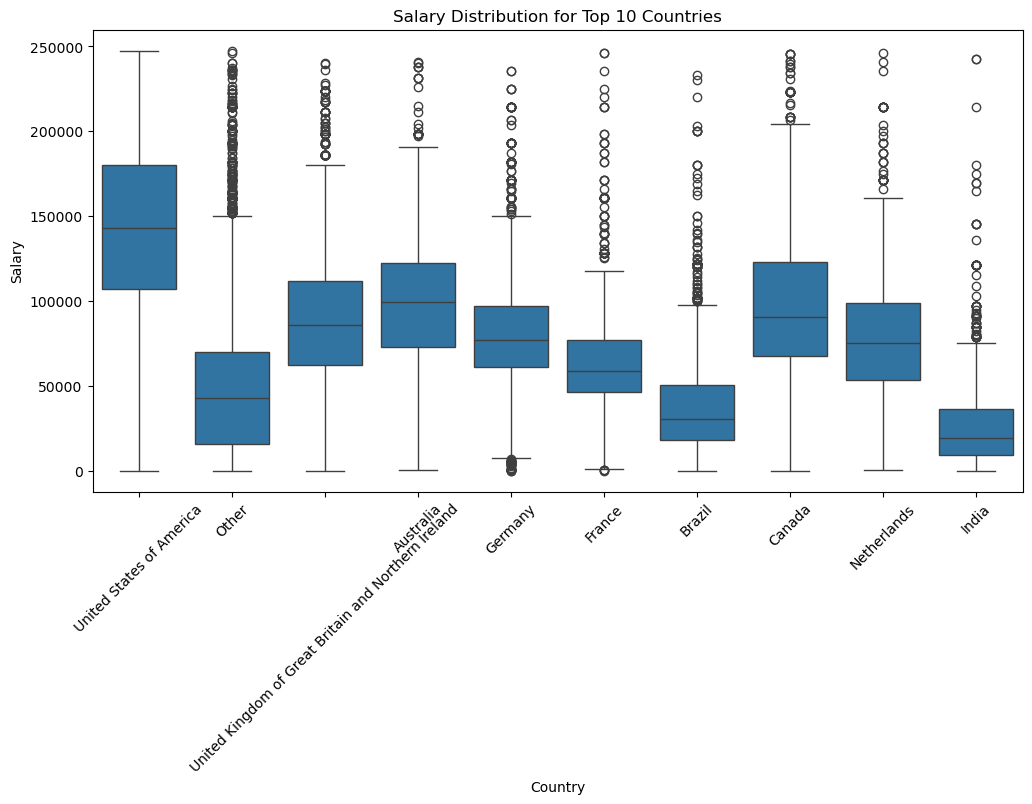

In [322]:
top_countries = df['Country'].value_counts().nlargest(10).index
df_top = df[df['Country'].isin(top_countries)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='Country', y='Salary', data=df_top)
plt.xticks(rotation=45)
plt.title('Salary Distribution for Top 10 Countries')
plt.show()

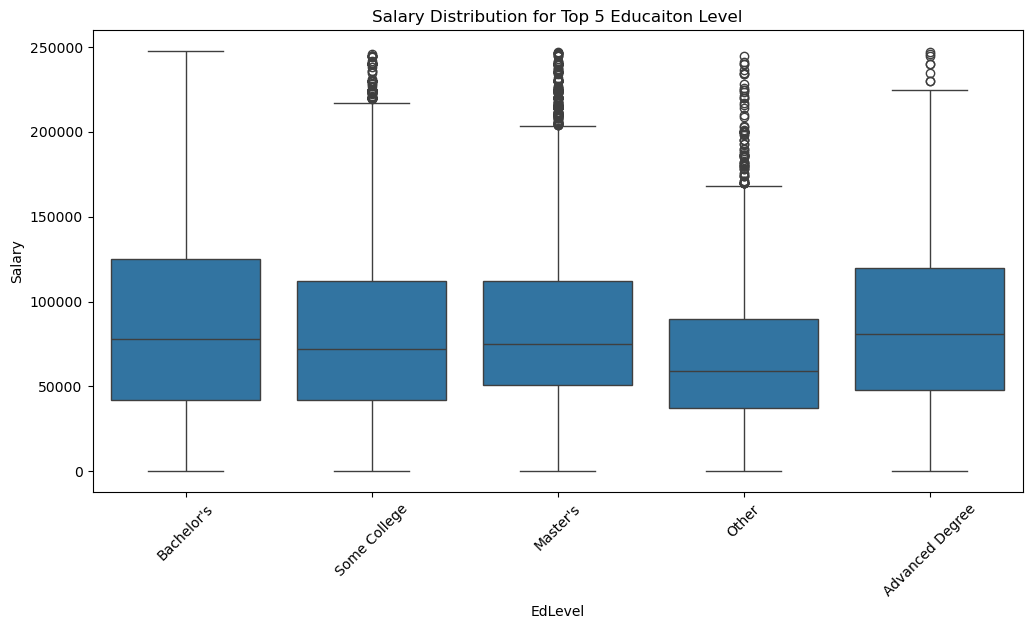

In [326]:
# Plot 3: Average Salary by Education Level
top_education = df['EdLevel'].value_counts().nlargest(5).index
df_top = df[df['EdLevel'].isin(top_education)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='EdLevel', y='Salary', data=df_top)
plt.xticks(rotation=45)
plt.title('Salary Distribution for Top 5 Educaiton Level')
plt.show()

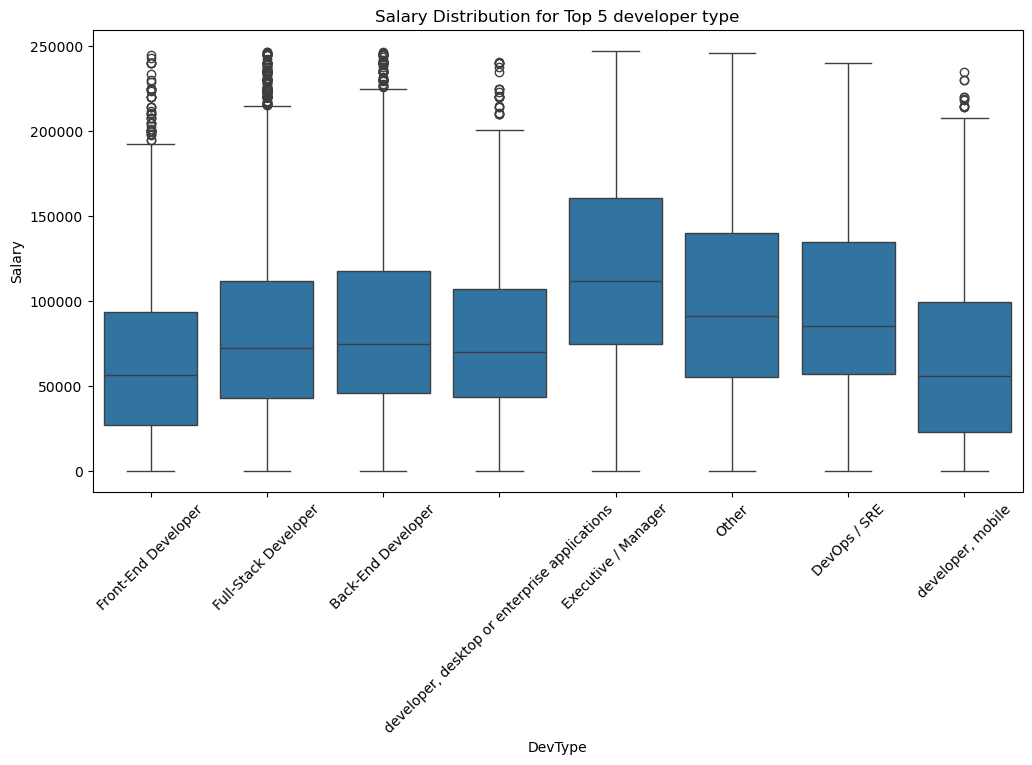

In [327]:
# Plot 4: Average Salary by Developer type
top_developer = df['DevType'].value_counts().nlargest(8).index
df_top = df[df['DevType'].isin(top_developer)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='DevType', y='Salary', data=df_top)
plt.xticks(rotation=45)
plt.title('Salary Distribution for Top 5 developer type')
plt.show()

In [296]:
# IQR-based outlier detection
Q1 = df['Salary'].quantile(0.25)
Q3 = df['Salary'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Salary'] < lower_bound) | (df['Salary'] > upper_bound)]

print(f"Number of outliers in Salary: {len(outliers)}")
print(outliers[['Salary']].head())  # Show some outliers

Number of outliers in Salary: 1460
        Salary
1     285000.0
315   280000.0
405   400000.0
570   280000.0
1000  372415.0


In [297]:
# Drop the outlier using IQR Method
Q1 = df['Salary'].quantile(0.25)   # First quartile (25%)
Q3 = df['Salary'].quantile(0.75)   # Third quartile (75%)
IQR = Q3 - Q1                      # Interquartile range

# Define bounds
lower_bound = Q1 - 1.5 * IQR

upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
df_iqr_filtered = df[(df['Salary'] >= lower_bound) & (df['Salary'] <= upper_bound)]

# Optionally, display how many rows were dropped
print(f"Original rows: {len(df)}")
print(f"Filtered rows: {len(df_iqr_filtered)}")
print(f"Outliers removed: {len(df) - len(df_iqr_filtered)}")

# Update the original DataFrame (optional)
df = df_iqr_filtered.copy()


Original rows: 34419
Filtered rows: 32959
Outliers removed: 1460


In [298]:
# Fix WorkMode column
df['WorkMode'] = df['WorkMode'].replace('Hybrid (some remote, some in-person)', 'Hybrid')
print(f"{df["WorkMode"].unique()}")

['Hybrid' 'Remote' 'In-person']


In [299]:
# Fix EdLevel column
# Original mapping to simplified levels
education_mapping = {
    "Bachelor’s degree (B.A., B.S., B.Eng., etc.)": "Bachelor's",
    "Some college/university study without earning a degree": "Some College",
    "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": "Master's",
    "Primary/elementary school": "Primary School",
    "Professional degree (JD, MD, Ph.D, Ed.D, etc.)": "Doctorate/Professional",
    "Associate degree (A.A., A.S., etc.)": "Associate",
    "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": "High School",
    "Something else": "Other"
}

# Grouping into broader categories
education_grouping = {
    "Bachelor's": "Bachelor's",
    "Master's": "Master's",
    "Some College": "Some College",
    "Doctorate/Professional": "Advanced Degree",
    "High School": "Other",
    "Primary School": "Other",
    "Associate": "Some College",  # Optional merge
    "Other": "Other"
}

df['EdLevel'] = df['EdLevel'].replace(education_mapping)
# replace simplified values with grouped categories
df['EdLevel'] = df['EdLevel'].replace(education_grouping)

In [300]:
# Fix Experience column
#Experience column still contains some string values like "Less than 1 year" or "More than 50 years" that weren't properly converted to numbers.
def convert_experience(val):
    if pd.isna(val):
        return np.nan
    if val == 'Less than 1 year':
        return float(0.5)
    elif val == 'More than 50 years':
        return float(51)
    try:
        return float(val)
    except:
        return np.nan

# Apply conversion
df['Experience'] = df['Experience'].apply(convert_experience)

In [301]:
df['DevType'].value_counts()

DevType
Developer, full-stack                            13492
Developer, back-end                               7267
Developer, front-end                              1780
Developer, desktop or enterprise applications     1128
Engineering manager                               1002
Developer, mobile                                  883
Other (please specify):                            879
DevOps specialist                                  778
Engineer, data                                     708
Data scientist or machine learning specialist      660
Cloud infrastructure engineer                      608
Senior Executive (C-Suite, VP, etc.)               591
Research & Development role                        389
Developer, embedded applications or devices        370
Data or business analyst                           248
Engineer, site reliability                         237
System administrator                               223
Developer, QA or test                              196
Ac

In [302]:
# Fix DevType column.
devtype_mapping = {
    'developer, full-stack': 'Full-Stack Developer',
    'developer, back-end': 'Back-End Developer',
    'developer, front-end': 'Front-End Developer',
    'mobile': 'Mobile Developer',
    'desktop or enterprise applications': 'Desktop Developer',
    'embedded applications or devices': 'Embedded/IoT Developer',
    'hardware engineer': 'Embedded/IoT Developer',
    'data': 'Data Analyst',
    'data or business analyst': 'Data Analyst',
    'data scientist or machine learning specialist': 'Data Scientist / ML',
    'scientist': 'Data Scientist / ML',
    'devops specialist': 'DevOps / SRE',
    'site reliability': 'DevOps / SRE',
    'cloud infrastructure engineer': 'DevOps / SRE',
    'system administrator': 'System Administrator',
    'database administrator': 'System Administrator',
    'project manager': 'Project/Product Manager',
    'product manager': 'Project/Product Manager',
    'designer': 'Designer/UX',
    'developer advocate': 'Developer Advocate',
    'developer experience': 'Developer Advocate',
    'academic researcher': 'Academic/Research',
    'research & development role': 'Academic/Research',
    'educator': 'Academic/Research',
    'marketing or sales professional': 'Marketing/Sales',
    'security professional': 'Security',
    'qa or test': 'QA / Test Engineer',
    'blockchain': 'Blockchain Developer',
    'engineering manager': 'Executive / Manager',
    'senior executive (c-suite, vp, etc.)': 'Executive / Manager',
    'game or graphics': 'Game/Graphics Developer',
    'student': 'Other',
    'other (please specify):': 'Other',
    'etc.)': 'Other',
    'marketing/sales': 'Other',
    'embedded/iot developer': 'Other',
    'other': 'Other'
}

df['DevType'] = df['DevType'].str.lower().replace(devtype_mapping)

In [303]:
df['DevType'].unique()

array(['Front-End Developer', 'Full-Stack Developer',
       'Back-End Developer', 'System Administrator', 'Designer/UX',
       'Security', 'developer, embedded applications or devices',
       'engineer, data', 'Project/Product Manager',
       'developer, desktop or enterprise applications',
       'Executive / Manager', 'Other', 'developer, qa or test',
       'Developer Advocate', 'Data Scientist / ML', 'DevOps / SRE',
       'developer, mobile', 'Data Analyst', 'Academic/Research',
       'Blockchain Developer', 'engineer, site reliability',
       'developer, game or graphics', 'Embedded/IoT Developer',
       'Marketing/Sales'], dtype=object)

In [304]:
# Work with "OrgSize" column.
orgsize_mapping = {
    'Just me - I am a freelancer, sole proprietor, etc.': 'Freelancer',
    '2 to 9 employees': 'Small(2 to 99)',
    '10 to 19 employees': 'Small(2 to 99)',
    '20 to 99 employees': 'Small(2 to 99)',
    '100 to 499 employees': 'Medium(100 to 499)',
    '500 to 999 employees': 'Medium(100 to 499)',
    '1,000 to 4,999 employees': 'Large(1,000 to 4,999)',
    '5,000 to 9,999 employees': 'Enterprise(More than 4,999)',
    '10,000 or more employees': 'Enterprise(More than 4,999)',
    'I don’t know': 'Unknown'
}

df['OrgSize'] = df['OrgSize'].replace(orgsize_mapping)
df['OrgSize'].unique()

array(['Medium(100 to 499)', 'Small(2 to 99)', 'Large(1,000 to 4,999)',
       'Freelancer', 'Enterprise(More than 4,999)', 'Unknown'],
      dtype=object)

In [305]:
# Fix "Country" column
country_counts = df['Country'].value_counts()
cumulative_percent = country_counts.head(20).sum() / country_counts.sum()
print(f"Top 20 countries cover {cumulative_percent:.2%} of data")

top_countries = df['Country'].value_counts().nlargest(20).index
# Replace all countries not in top 20 with 'Other'
df['Country'] = df['Country'].apply(lambda x: x if x in top_countries else 'Other')
df['Country'].unique()

Top 20 countries cover 76.19% of data


array(['United States of America', 'Other',
       'United Kingdom of Great Britain and Northern Ireland', 'Finland',
       'Australia', 'Germany', 'Sweden', 'France', 'Spain', 'Brazil',
       'Italy', 'Canada', 'Switzerland', 'Netherlands', 'India', 'Norway',
       'Poland', 'Portugal', 'Austria', 'Denmark', 'Israel'], dtype=object)

In [306]:
df.groupby('Country')['Salary'].median().sort_values()

Country
India                                                    19387.0
Brazil                                                   30431.0
Other                                                    42492.0
Italy                                                    43907.0
Spain                                                    53545.0
Portugal                                                 57914.0
France                                                   58899.0
Sweden                                                   59892.0
Poland                                                   62208.0
Finland                                                  69608.0
Austria                                                  72821.0
Netherlands                                              74963.0
Norway                                                   77021.0
Germany                                                  77104.0
United Kingdom of Great Britain and Northern Ireland     85841.5
Canada           

In [307]:
df['DevType'].value_counts()

DevType
Full-Stack Developer                             13492
Back-End Developer                                7267
Front-End Developer                               1780
Executive / Manager                               1593
DevOps / SRE                                      1386
developer, desktop or enterprise applications     1128
Other                                              890
developer, mobile                                  883
Data Scientist / ML                                718
engineer, data                                     708
Academic/Research                                  663
developer, embedded applications or devices        370
Project/Product Manager                            328
System Administrator                               321
Data Analyst                                       248
engineer, site reliability                         237
Developer Advocate                                 204
developer, qa or test                              196
de

In [308]:
# 2. Define columns
multi_label_cols = ['Language', 'DataBase', 'Platform']
cat_cols = ['WorkMode', 'EdLevel','DevType','OrgSize', 'Country']
num_cols = ['Experience']

In [309]:
class MultiLabelBinarizerDF(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, delimiter=';', top_n=10):
        self.columns = columns
        self.delimiter = delimiter
        self.top_n = top_n
        self.top_labels_ = {}            # Stores top-N labels per column
        self.label_binarizers = {}       # Stores the MultiLabelBinarizer per column

    def fit(self, X, y=None):
        for col in self.columns:
            # Flatten all items in the column
            all_items = X[col].dropna().apply(
                lambda x: [i.strip() for i in str(x).split(self.delimiter)]
            ).explode()

            # Get top-N labels
            top_items = [item for item, _ in Counter(all_items).most_common(self.top_n)]
            self.top_labels_[col] = top_items

            # Prepare cleaned labels for fitting
            cleaned = X[col].dropna().apply(lambda x: self._clean_labels(x, top_items))
            mlb = MultiLabelBinarizer()
            mlb.fit(cleaned)
            self.label_binarizers[col] = mlb

        return self
    def transform(self, X):
        encoded_frames = []
        for col in self.columns:
            cleaned = X[col].fillna('').apply(
                lambda x: self._clean_labels(x, self.top_labels_[col])
            )
            encoded = self.label_binarizers[col].transform(cleaned)
            columns = [f"{col}_{cls}" for cls in self.label_binarizers[col].classes_]
            df_encoded = pd.DataFrame(encoded, columns=columns, index=X.index)
            encoded_frames.append(df_encoded)
        return pd.concat(encoded_frames, axis=1)

    def _clean_labels(self, val, top_items):
        # Split and strip
        items = [i.strip() for i in str(val).split(self.delimiter) if i.strip()]

        # Map infrequent labels to 'Other', keep unique
        cleaned = [i if i in top_items else 'Other' for i in items]
        return list(dict.fromkeys(cleaned))




In [310]:
# Preprocessors
multi_label_processor = MultiLabelBinarizerDF(columns=multi_label_cols, delimiter=';', top_n=20)
cat_processor = OneHotEncoder(handle_unknown='ignore')
num_processor = StandardScaler()

In [311]:
# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('multi_label', multi_label_processor, multi_label_cols),
    ('categorical', cat_processor, cat_cols),
    ('numerical', num_processor, num_cols)
])
preprocessor

ColumnTransformer(transformers=[('multi_label',
                                 MultiLabelBinarizerDF(columns=['Language',
                                                                'DataBase',
                                                                'Platform'],
                                                       top_n=20),
                                 ['Language', 'DataBase', 'Platform']),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['WorkMode', 'EdLevel', 'DevType', 'OrgSize',
                                  'Country']),
                                ('numerical', StandardScaler(),
                                 ['Experience'])])

In [312]:
# Final pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('xgb', XGBRegressor(
    objective='reg:squarederror',
    n_estimators=938,
    learning_rate=0.1051,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.7117,
    random_state=42,
    n_jobs=-1
))
])
model_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('multi_label',
                                                  MultiLabelBinarizerDF(columns=['Language',
                                                                                 'DataBase',
                                                                                 'Platform'],
                                                                        top_n=20),
                                                  ['Language', 'DataBase',
                                                   'Platform']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['WorkMode', 'EdLevel',
                                                   'DevType', 'OrgSize',
                                                   'Country']),
                                                 ('numerical', StandardScaler(),
                                                  ['Experience'])])),
                ('...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.1051, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=938, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [313]:
# Prepare train/test sets
X = df.drop("Salary", axis=1)
y = df["Salary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [314]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('multi_label',
                                                  MultiLabelBinarizerDF(columns=['Language',
                                                                                 'DataBase',
                                                                                 'Platform'],
                                                                        top_n=20),
                                                  ['Language', 'DataBase',
                                                   'Platform']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['WorkMode', 'EdLevel',
                                                   'DevType', 'OrgSize',
                                                   'Country']),
                                                 ('numerical', StandardScaler(),
                                                  ['Experience'])])),
                ('...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.1051, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=938, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [315]:
# predict
y_pred = model_pipeline.predict(X_test)

In [316]:
# Evaluate
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R² Score: 0.6394589901197023
MSE: 1075352998.8448951
RMSE: 1075352998.8448951
MAE: 23603.66134489335


In [317]:
with open("salary_pipeline.pkl", "wb") as f:
    pickle.dump(model_pipeline, f)